# АВ-тест и анализ результатов

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.  
  
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.  
  
Задача — проанализировать данные АB-теста.  
Сравнить CTR, используя t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5), а также t-тест и тест Манна-Уитни поверх бакетного преобразования.  
Почему тесты сработали так как сработали? Опишите потенциальную ситуацию, когда такое изменение могло произойти.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandahouse
from scipy import stats
import seaborn as sns
import numpy as np

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    count(DISTINCT post_id) as posts,
    likes/views as ctr
FROM simulator_20230320.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df.head()

,exp_group,user_id,likes,views,posts,ctr
0,1,109963,3,15,15,0.200000
1,1,26117,32,141,91,0.226950
2,1,138232,18,73,55,0.246575
3,1,26295,33,122,87,0.270492
4,1,18392,7,32,27,0.218750


In [4]:
df.shape

(20031, 6)

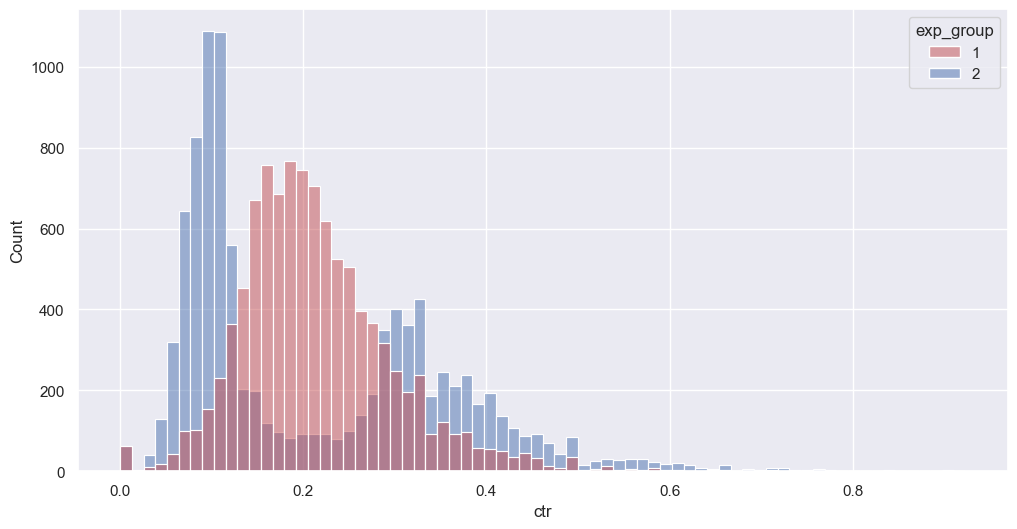

In [5]:
sns.set(rc={"figure.figsize":(12, 6)}) 
ax = sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'])

Распределение в контрольной группе близко к нормальному. Визуально CTR во 2 группе не увеличился, скорее уменьшился.

In [6]:
# Статистики по контрольной 2-й группе
df[df['exp_group']==1].ctr.describe()

count    10079.000000
mean         0.215605
std          0.084160
min          0.000000
25%          0.160097
50%          0.203125
75%          0.257654
max          0.722222
Name: ctr, dtype: float64

In [7]:
# Статистики по контрольной 2-й группе
df[df['exp_group']==2].ctr.describe()

count    9952.000000
mean        0.214419
std         0.144180
min         0.000000
25%         0.095238
50%         0.142857
75%         0.325000
max         0.923077
Name: ctr, dtype: float64

## t-тест Стьюдента

H0 - средние значения CTR в контрольной и экспериментальной группaх равны.  
H1 - средние значения CTR в тестовой группе выше, чем в контрольной.

In [8]:
alpha = 0.05
results = stats.ttest_ind(df[df['exp_group']==2].ctr, 
                df[df['exp_group']==1].ctr, 
                equal_var=False,
                alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.7609688434562533
Не отвергаем нулевую гипотезу


H0 - средние значения CTR в контрольной и экспериментальной группaх равны.  
H1 - средние значения CTR в тестовой группе ниже, чем в контрольной.

In [9]:
# Проверим обратную гипотезу о том, что среднее CTR контрольной группы (1) больше, чем CTR тестовой (2)
results = stats.ttest_ind(df[df['exp_group']==2].ctr, 
                df[df['exp_group']==1].ctr, 
                equal_var=False,
                alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.23903115654374674
Не отвергаем нулевую гипотезу


t-тест Стьюдента сравнивает средние, поэтому по результатом этого теста делаем вывод, что средние значения CTR в контрольной и экспериментальной группaх равны.

## Тест Манна-Уитни

In [10]:
results = stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr, 
                   alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.0
Не отвергаем нулевую гипотезу


In [11]:
results = stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr, 
                   alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 3.0188242308889518e-56
Отвергаем нулевую гипотезу


Гипотезы теста Манна-Уитни  
H0: две функций распределения равны `P(X > Y ) = P(Y > X)`   
H1: доминирование одной из функции `P(X > Y ) != P(Y > X)`  
Результат теста показывает, что распределение контрольной группы доминирует т. е. вероятность получить бОльшие значения CTR в контрольной группе выше, чем в тестовой.

## Сглаженный CTR

Применим "сглаживание" CTR для более корректной оценки CTR пользователей с низким количеством просмотров.

$$ smoothed_CTRu = (clicksu + α∗globalCTR)/(views + α) $$
alphaα — гиперпараметр. Идея проста: когда просмотров много, сглаженный CTR почти равен CTR пользователя. Когда просмотров мало, сглаженный CTR почти равен общегрупповому CTR. 



In [12]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha=5):
    '''
    функция get_smoothed_ctr преобразует пользовательский CTR в сглаженный CTR
    
    Параметры:
    user_likes - лайки пользователя
    user_views - просмотры пользователя
    global_ctr - общий CTR по группе
    alpha - коэффициент сглаживания

    Функция возвращает: 
    smoothed_ctr - значение сглаженного CTR
    '''
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [13]:
# Глобальный CTR контрольной 1-й группы
global_ctr_1 = df[df['exp_group'] == 1].likes.sum()/df[df['exp_group'] == 1].views.sum()
print('Глобальный CTR 1 группы:', global_ctr_1)
# Глобальный CTR тестовой 2-й группы
global_ctr_2 = df[df['exp_group'] == 2].likes.sum()/df[df['exp_group'] == 2].views.sum()
print('Глобальный CTR 2 группы:', global_ctr_2)

Глобальный CTR 1 группы: 0.20802680490126244
Глобальный CTR 2 группы: 0.1980601844115994


In [14]:
# Добавим столбец smoothed_ctr в df
df.loc[df['exp_group'] == 1, 'smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1)
df.loc[df['exp_group'] == 2, 'smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1)


<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

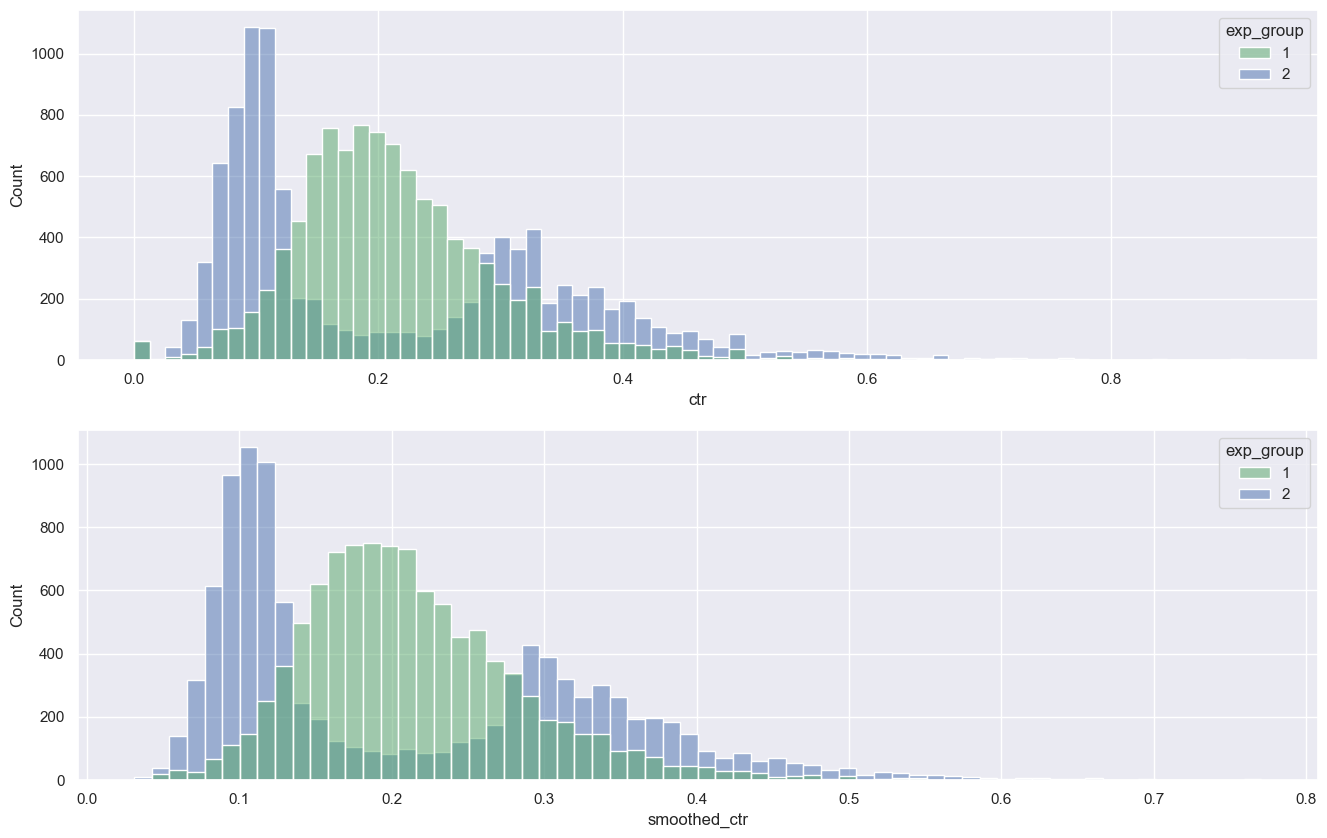

In [15]:
f, axs = plt.subplots(2,1, figsize=(16,10))
sns.histplot(df, x='ctr', hue='exp_group', palette=['g','b'], ax=axs[0])
sns.histplot(df, x='smoothed_ctr', hue='exp_group', palette=['g','b'], ax=axs[1])

CTR сгладился, выбросов меньше. Можно повторно провести тест Стьюдента, так как именно он зависит от выбросов.

### t-тест Стьюдента на сглаженном CTR

H0 - средние значения сглаженного CTR в контрольной и экспериментальной группaх равны.  
H1 - средние значения сглаженного CTR в тестовой группе выше, чем в контрольной.

In [16]:
results = stats.ttest_ind(df[df['exp_group']==2].smoothed_ctr, 
                df[df['exp_group']==1].smoothed_ctr, 
                equal_var=False,
                alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.9888115092220721
Не отвергаем нулевую гипотезу


H0 - средние значения сглаженного CTR в контрольной и экспериментальной группaх равны.  
H1 - средние значения сглаженного CTR в тестовой группе ниже, чем в контрольной.

In [17]:
results = stats.ttest_ind(df[df['exp_group']==2].smoothed_ctr, 
                df[df['exp_group']==1].smoothed_ctr, 
                equal_var=False,
                alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.01118849077792795
Отвергаем нулевую гипотезу


Результат: средние значения сглаженного CTR в тестовой группе ниже, чем в контрольной.

## Пуассоновский бутстреп

Многократный счет общегруппового CTR по псевдовыборкам из тестовой (2) и контрольной (1) групп.

1. Берем выборку из группы А  
2. Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее weights_1weights 
3. Считаем «глобальный CTR» по псевдовыборке для: A globalCTR_A
4. Берем выборку из группы B 
5. Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее weights_2weights 
6. Считаем «глобальный CTR» по псевдовыборке для BB: globalCTR_B
7. Считаем разницу между globalCTR_A - globalCTR_B и записываем ее в список 
Повторяем процедуру много раз.

In [18]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    '''
    функция bootstrap многократно рассчитывает глобальный CTR по псевдовыборкам из каждой группы
    
    Параметры:
    likes1 - количество лайков пользователей из 1-й группы
    likes2 - количество лайков пользователей из 2-й группы
    views1 - количество просмотров пользователей из 1-й группы
    views2 - количество просмотров пользователей из 2-й группы

    Функция возвращает: 
    globalCTR1 - общий CTR по 1-й группе 
    globalCTR2 - общий CTR по 2-й группе 
    '''
    # Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку» для 1-й и 2-й группы
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    # Считаем глобальный CTR для каждой группы
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [19]:
# Лайки и просмотры для 1-й (контрольной) группы
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
# Лайки и просмотры для 2-й (тестовой) группы
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [20]:
# Глобальный CTR для 1-й и 2-й групп
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

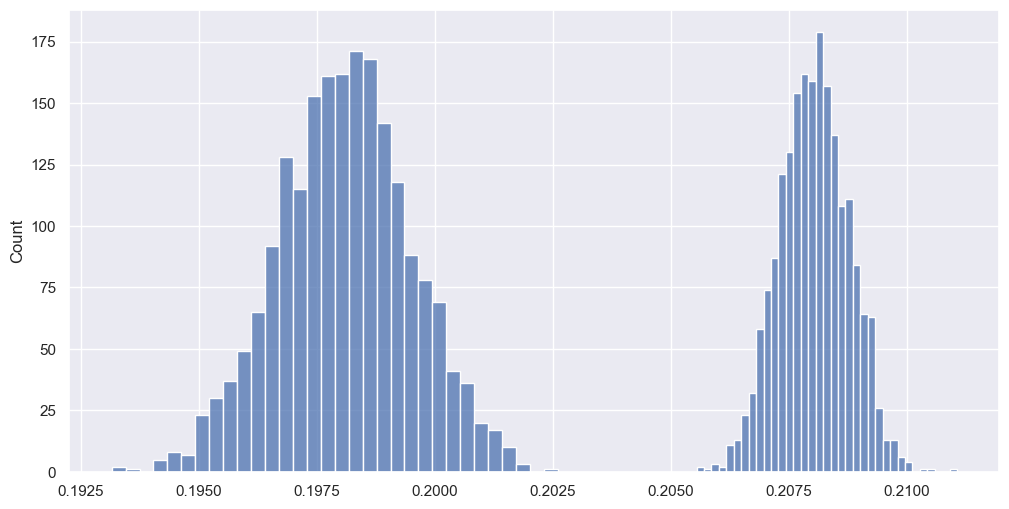

In [21]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

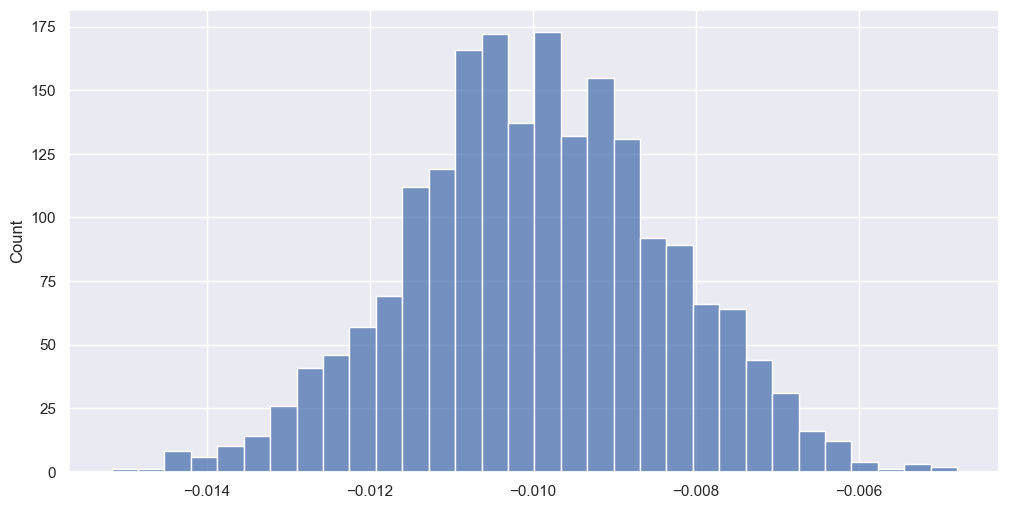

In [22]:
sns.histplot(ctr2 - ctr1)

Разница положительная. Все значения в 1 группе больше, чем во 2-й. Соответственно, можем утверждать, что новый алгоритм не приведет к увеличению CTR пользователей.


### t-тест Стьюдента на пуассоновском бутстрепе

H0 - средние значения CTR в контрольной и экспериментальной группaх равны.  
H1 - средние значения CTR в тестовой группе выше, чем в контрольной.

In [23]:
results = stats.ttest_ind(ctr1, 
                ctr2, 
                equal_var=False,
                alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


In [24]:
results = stats.ttest_ind(ctr1, 
                ctr2, 
                equal_var=False,
                alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Распределения приблизились к нормальному и тест Стьюдента заметил различие средних.

### Тест Манна-Уитни на пуассоновском бутстрепе

In [25]:
results = stats.mannwhitneyu(ctr1, 
                   ctr2, 
                   alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


In [26]:
results = stats.mannwhitneyu(ctr1, 
                   ctr2, 
                   alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.0
Не отвергаем нулевую гипотезу


## Бакетное преобразование

In [27]:
# Разбиение на 50 бакетов
q = """
    SELECT 
        exp_group, bucket,
        sum(likes)/sum(views) as bucket_ctr
    FROM 
        (SELECT 
            exp_group,
            xxHash64(user_id)%50 as bucket,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM 
            simulator_20230320.feed_actions
        WHERE 
            (toDate(time) BETWEEN '2023-03-02' AND '2023-03-08')
            AND (exp_group IN (1, 2))
        GROUP BY 
            exp_group, bucket, user_id)
    GROUP BY 
        exp_group, bucket
"""
# Сохраним результат запроса в pandas df
df_b = pandahouse.read_clickhouse(q, connection=connection)

In [28]:
df_b.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


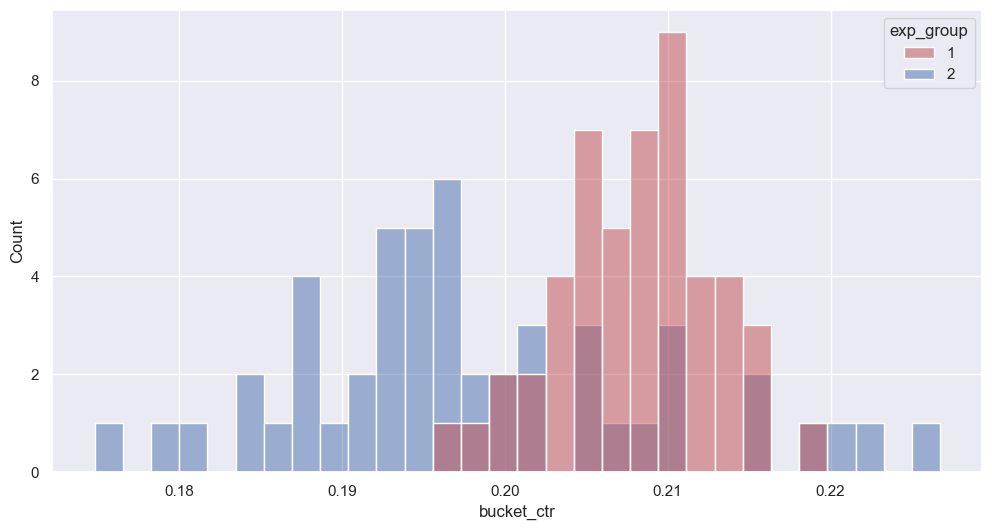

In [29]:
sns.set(rc={"figure.figsize":(12, 6)}) 
ax = sns.histplot(data=df_b, x='bucket_ctr', hue='exp_group', palette=['r', 'b'], bins=30)


###  t-тест Стьюдента на бакетном преобразовании

H0 - средние значения CTR в контрольной и экспериментальной группaх равны.  
H1 - средние значения CTR в тестовой группе выше, чем в контрольной.

In [30]:
results = stats.ttest_ind(df_b[df_b['exp_group']==2].bucket_ctr, 
                df_b[df_b['exp_group']==1].bucket_ctr, 
                equal_var=False,
                alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.9999998277202418
Не отвергаем нулевую гипотезу


In [31]:
results = stats.ttest_ind(df_b[df_b['exp_group']==2].bucket_ctr, 
                df_b[df_b['exp_group']==1].bucket_ctr, 
                equal_var=False,
                alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.7227975824972953e-07
Отвергаем нулевую гипотезу


### Тест Манна-Уитни на бакетном преобразовании

In [32]:
results = stats.mannwhitneyu(df_b[df_b['exp_group']==2].bucket_ctr, 
                   df_b[df_b['exp_group']==1].bucket_ctr, 
                   alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.9999998621494246
Не отвергаем нулевую гипотезу


In [33]:
results = stats.mannwhitneyu(df_b[df_b['exp_group']==2].bucket_ctr, 
                   df_b[df_b['exp_group']==1].bucket_ctr, 
                   alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 1.429981968246323e-07
Отвергаем нулевую гипотезу


## Выводы по тестированию

А/В тестирование показало, что новый алгоритм не привел к увеличению CTR, наоборот, CTR даже снизился в тестовой группе. Это могло произойти из-за того, что алгоритм стал предлагать неинтересные посты, и количество лайков снизилось или количество просмотров сильно увеличилось, но при этом новые посты не интересны, и поэтому количество лайков не увеличилось, что привело к снижению CTR.

## Исследование лайков и просмотров

[Text(0.5, 1.0, 'Количество постов по группам')]

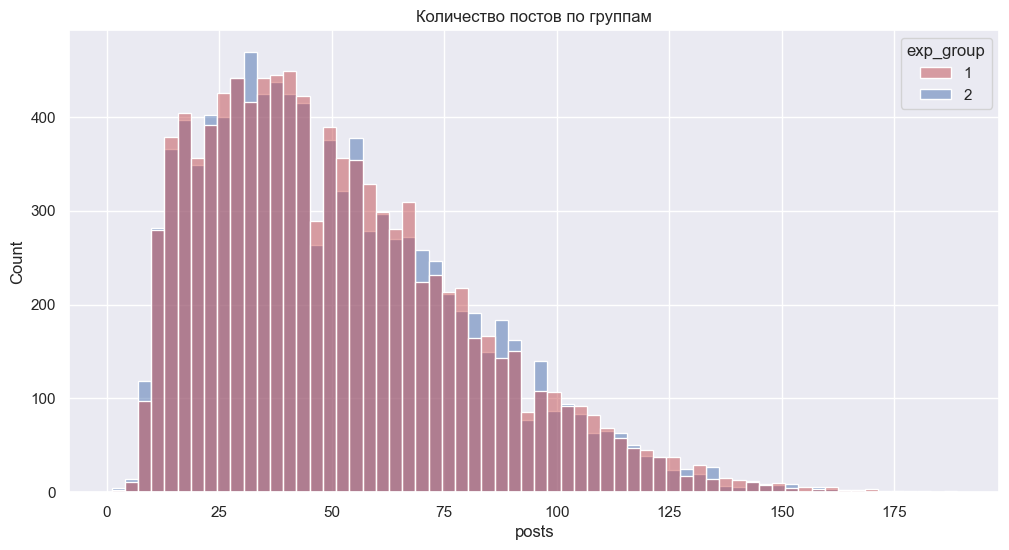

In [34]:
sns.histplot(data=df, x='posts', hue='exp_group', palette=['r', 'b']).set(title='Количество постов по группам')

[Text(0.5, 1.0, 'Количество просмотров по группам')]

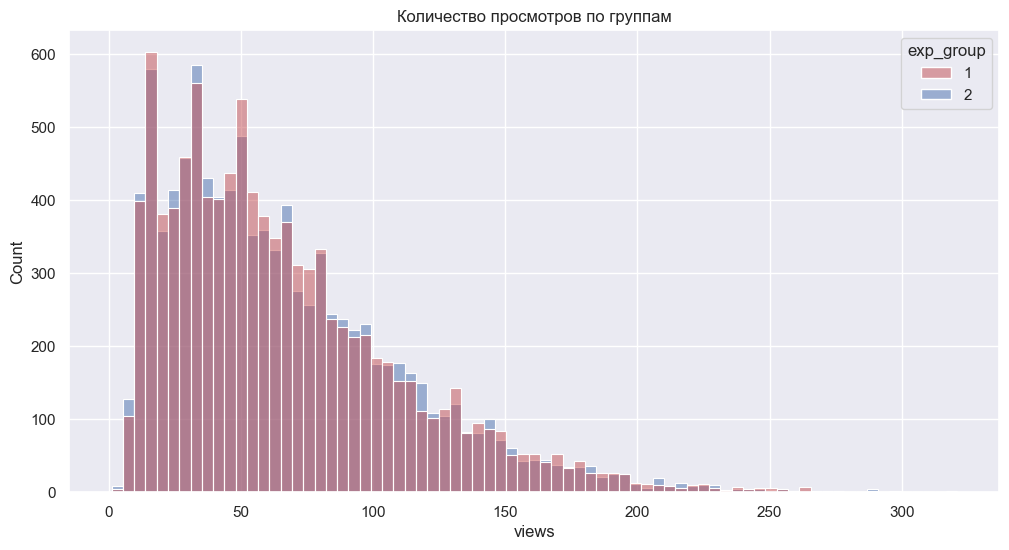

In [35]:
sns.histplot(data=df, x='views', hue='exp_group', palette=['r', 'b']).set(title='Количество просмотров по группам')

[Text(0.5, 1.0, 'Количество лайков по группам')]

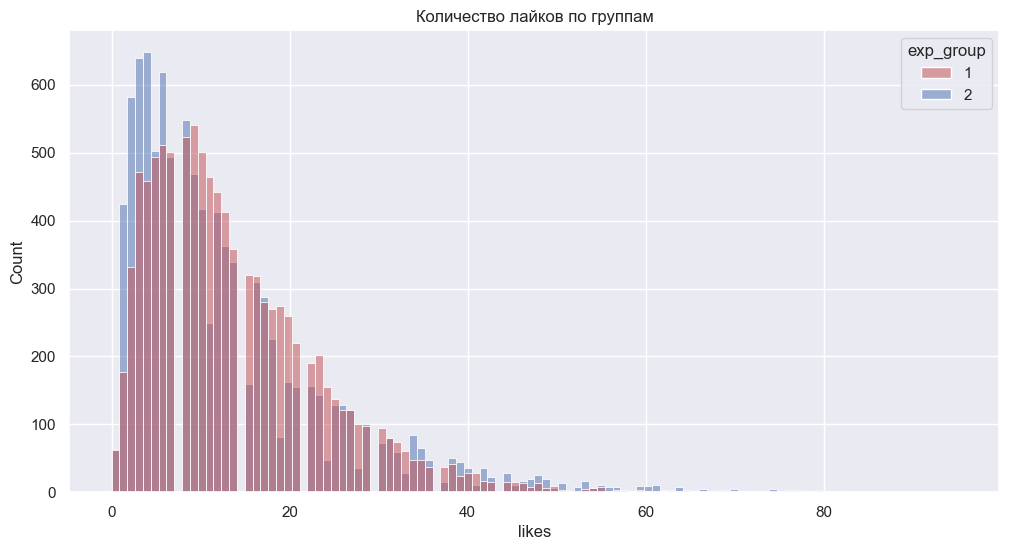

In [36]:
sns.histplot(data=df, x='likes', hue='exp_group', palette=['r', 'b']).set(title='Количество лайков по группам')

# Вывод

Новый алгоритм показывает посты, которые не нравятся пользователям (кол-во лайков уменьшилось, при таком же обьеме постов и просмотров). Не рукомендуется раскатывать этот алгоритм.